# Paper Grading Assistant

## Modeling

Data comes from this link:
- https://www.kaggle.com/c/asap-aes/data

Heavy inspiration drawn from:
- https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
(Use incognito window when opening that link)

In [1]:
# !pip install gensim
import os, sys
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re


In [48]:
# Helper Functions
# Run the utilty functions from a seperate notebook
%run topic_model_utils.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxw2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data = pd.read_csv("D:\\Kaggle\\asap-aes\\training_set_rel3.tsv", sep='\t')
data = replicate_csv(data)
# data.head()

<ipython-input-2-5199df266e47>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 2
<ipython-input-2-5199df266e47>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 3
<ipython-input-2-5199df266e47>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'][x] = 4
<ipython-input-2-5199df266e47>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [4]:
# drop some unused features
cols_to_drop = [col for col in data.columns if 'rater' in col]
data = data.drop(columns=cols_to_drop)

data

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2
...,...,...,...,...,...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35,0.0,"[story, mother, daughter, enemy, friend, point...",848,60,0.583333,1
12972,21628,8,I never understood the meaning laughter is th...,32,0.0,"[understood, meaning, laughter, shortest, dist...",548,60,0.533333,1
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40,0.0,"[laugh, habit, cause, laughing, thing, laughte...",818,60,0.666667,2
12974,21630,8,Trippin' on fen...,40,0.0,"[trippin, fence, num, year, young, short, reme...",594,60,0.666667,2


In [5]:
df = data[data['word_count'] > 25]
df

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2
...,...,...,...,...,...,...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35,0.0,"[story, mother, daughter, enemy, friend, point...",848,60,0.583333,1
12972,21628,8,I never understood the meaning laughter is th...,32,0.0,"[understood, meaning, laughter, shortest, dist...",548,60,0.533333,1
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40,0.0,"[laugh, habit, cause, laughing, thing, laughte...",818,60,0.666667,2
12974,21630,8,Trippin' on fen...,40,0.0,"[trippin, fence, num, year, young, short, reme...",594,60,0.666667,2


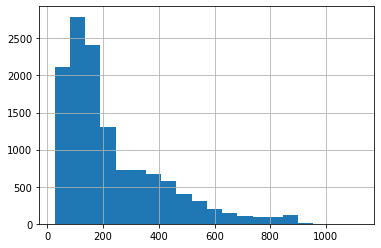

In [6]:
df['word_count'].hist(bins=20);

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.85, 
                                   min_df=3, 
                                   max_features=no_features, 
                                   stop_words='english', 
                                   preprocessor=' '.join)
tfidf = tfidf_vectorizer.fit_transform(df['tokenized_essay']) # tfidf embeddings
# print("tfidf: \n", tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, 
                                min_df=3, 
                                max_features=no_features, 
                                stop_words='english', 
                                preprocessor=' '.join)
tf = tf_vectorizer.fit_transform(df['tokenized_essay']) # tf embeddings
# print("tf: \n", tf)
tf_feature_names = tf_vectorizer.get_feature_names()

In [8]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

n_components = 10

# Run NMF
nmf = NMF(n_components=n_components, random_state=1, 
          alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)



In [9]:
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
nmf_docweights = nmf.transform(tfidf_vectorizer.transform(df['tokenized_essay']))

n_top_words = 10

nmf_topic_df = topic_table(
    nmf,
    tfidf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
nmf_topic_df['topics'] = nmf_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
nmf_topic_df['topics'] = nmf_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
nmf_topic_df['topics'] = nmf_topic_df['topics'].str[0]  # Removing the list brackets

nmf_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,topics
0,book,library,shelf,offensive,movie,read,magazine,music,material,certain,book library shelf offensive movie read magazi...
1,area,law,wind,hydrogen,dirigible,low,urban,empire,airship,building,area law wind hydrogen dirigible low urban emp...
2,concludes,story,author,paragraph,test,saeng,plant,hibiscus,winter,flower,concludes story author paragraph test saeng pl...
3,mood,memoir,parent,created,narciso,family,love,grateful,author,rodriguez,mood memoir parent created narciso family love...
4,cyclist,setting,water,feature,affect,road,hill,hot,affected,desert,cyclist setting water feature affect road hill...


In [10]:
# Do the same with bag of words weight
# to create 'topics'

lda_docweights = lda.transform(tf_vectorizer.transform(df['tokenized_essay']))

n_top_words = 10

lda_topic_df = topic_table(
    lda,
    tf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
lda_topic_df['topics'] = lda_topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
lda_topic_df['topics'] = lda_topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
lda_topic_df['topics'] = lda_topic_df['topics'].str[0]  # Removing the list brackets

lda_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,topics
0,laughter,laughing,laugh,make,waited,sat,didn,life,best,funny,laughter laughing laugh make waited sat didn l...
1,water,setting,cyclist,feature,affect,road,hill,hot,affected,desert,water setting cyclist feature affect road hill...
2,time,got,day,patient,went,num,going,mom,person,hour,time got day patient went num going mom person...
3,pas,meant,immigrant,began,describes,word,explains,showed,share,sense,pas meant immigrant began describes word expla...
4,building,obstacle,empire,faced,wind,law,attempting,low,highly,frame,building obstacle empire faced wind law attemp...


In [11]:

# Create a df with only the created topics and topic num
lda_topic_df = lda_topic_df['topics'].reset_index()
lda_topic_df.columns = ['lda_topic_num', 'topics']

lda_topic_df.head()

,lda_topic_num,topics
0,0,laughter laughing laugh make waited sat didn l...
1,1,water setting cyclist feature affect road hill...
2,2,time got day patient went num going mom person...
3,3,pas meant immigrant began describes word expla...
4,4,building obstacle empire faced wind law attemp...


In [12]:

# Create a df with only the created topics and topic num
nmf_topic_df = nmf_topic_df['topics'].reset_index()
nmf_topic_df.columns = ['nmf_topic_num', 'topics']

nmf_topic_df.head()

,nmf_topic_num,topics
0,0,book library shelf offensive movie read magazi...
1,1,area law wind hydrogen dirigible low urban emp...
2,2,concludes story author paragraph test saeng pl...
3,3,mood memoir parent created narciso family love...
4,4,cyclist setting water feature affect road hill...


In [13]:
# Creating a temp df with the id and topic num to join on
id_ = df['essay_id'].tolist()
df_temp1 = pd.DataFrame({
    'essay_id': id_,
    'nmf_topic_num': nmf_docweights.argmax(axis=1)
})

merged_topic1 = df_temp1.merge(
    nmf_topic_df,
    on='nmf_topic_num',
    how='left'
)

df_temp2 = pd.DataFrame({
    'essay_id': id_,
    'lda_topic_num': lda_docweights.argmax(axis=1)
})

merged_topic2 = df_temp2.merge(
    lda_topic_df,
    on='lda_topic_num',
    how='left'
)

# Merging to get the topic num with id
merged_topic = merged_topic1.merge(
    merged_topic2,
    on='essay_id',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    df,
    merged_topic,
    on='essay_id',
    how='left'
)

df_topics = df_topics.rename(columns={'topics_x' : 'nmf_topic', 'topics_y' : 'lda_topic' })

df_topics.head(15)

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class,nmf_topic_num,nmf_topic,lda_topic_num,lda_topic
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
5,6,1,"Dear @LOCATION1, I think that computers have a...",8,0.0,"[dear, location, think, computer, negative, af...",246,12,0.666667,2,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
6,7,1,Did you know that more and more people these d...,10,0.0,"[did, know, people, day, depending, computer, ...",499,12,0.833333,4,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
7,8,1,@PERCENT1 of people agree that computers make ...,10,0.0,"[percent, people, agree, computer, make, life,...",482,12,0.833333,4,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
8,9,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",9,0.0,"[dear, reader, organization, dramatic, effect,...",443,12,0.750000,3,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...
9,10,1,In the @LOCATION1 we have the technology of a ...,9,0.0,"[location, technology, computer, good, society...",502,12,0.750000,3,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...


In [14]:

A = tfidf_vectorizer.transform(df_topics['essay'])
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
print('Sum of the squared residuals is {}'.format(sum_sqrt_res))

A = 12793 x 1000
W = 10 x 1000
H = 12793 x 10
Sum of the squared residuals is 0.0


In [15]:
def add_carriage_returns(text):
    arr = text.split(' ')
    for i in range(len(arr)):
        if i % 15 == 0:
            arr.insert(i, '\n')
    text = " ".join(arr)
    return text

# df_topics['essay'] = df_topics['essay'].apply(add_carriage_returns)

def print_lines(idx):
    print('=====')
    print('entry: ', idx)
    print(df_topics['essay'][idx])
    print(' ')
    print('Topics:')
    print("nmf topics:", df_topics['nmf_topic'][idx])
    print("lda topics:", df_topics['lda_topic'][idx])
    print('=====')

for i in range(0,20):
    print_lines(i)

=====
entry:  0
Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question a

In [16]:
def build_wordcloud(feature_count, vectorizer):
    from wordcloud import WordCloud
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

    n_entries = 20

    vals_to_display = feature_count.sort_values(by='feat_count', ascending=False).head(n_entries)

    ax2.bar(x=vals_to_display.feat_name.values, height=vals_to_display.feat_count.values)

    # define a wordcloud
    wc = WordCloud(background_color="white")
    wc.generate(" ".join(vectorizer.get_feature_names()))

    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis("off")

    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.show()

In [17]:
tf_feature_count = pd.DataFrame({
    "feat_name": tf_feature_names, 
    "feat_count": tf.toarray().sum(axis=0).tolist()
})
tf_feature_count.sort_values(by='feat_count', ascending=False).head(20)


,feat_name,feat_count
643,people,5224
894,time,4822
885,thing,4594
959,way,4165
886,think,3909
538,make,3782
506,life,3567
602,num,3293
473,know,3229
363,going,3118


In [18]:
tfidf_feature_count = pd.DataFrame({
    "feat_name": tfidf_feature_names, 
    "feat_count": tfidf.toarray().sum(axis=0).tolist()
})
tfidf_feature_count.sort_values(by='feat_count', ascending=False).head(20)

,feat_name,feat_count
50,author,400.760479
894,time,391.626917
643,people,377.472316
832,story,375.133474
885,thing,366.922897
886,think,349.172152
959,way,345.621321
538,make,328.140070
506,life,322.622953
602,num,317.744739


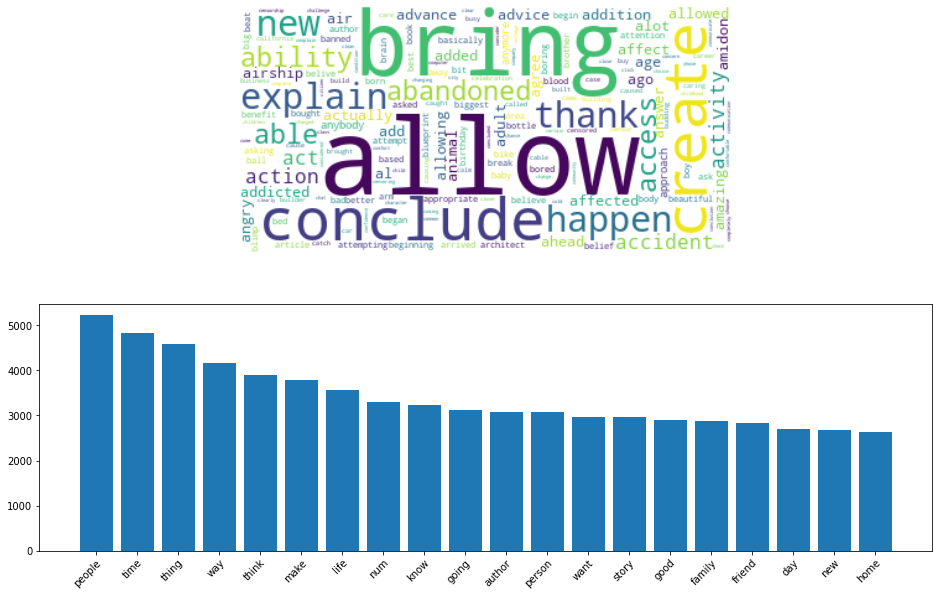

In [19]:
build_wordcloud(tf_feature_count, tf_vectorizer)

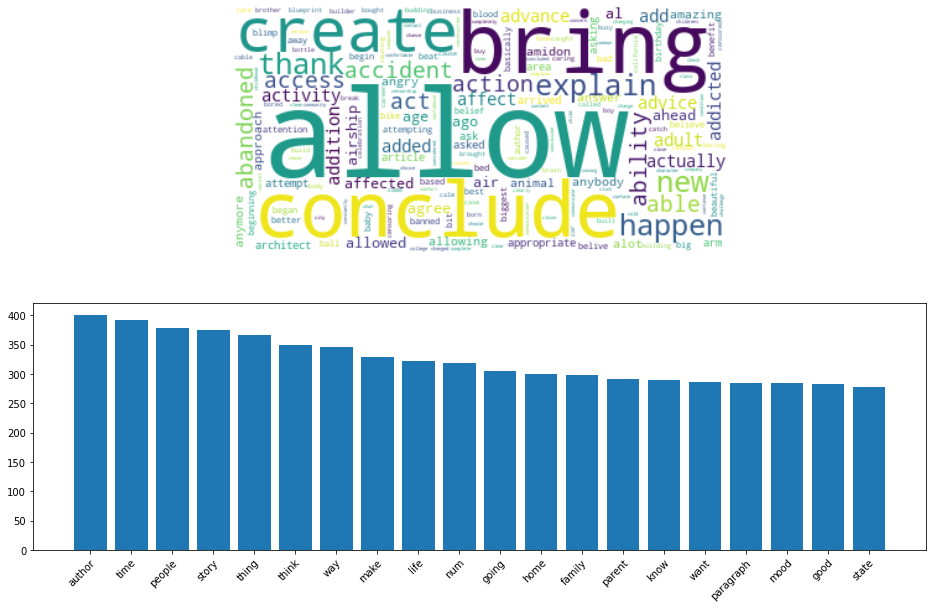

In [20]:
build_wordcloud(tfidf_feature_count, tfidf_vectorizer)

In [21]:
# takes about 1.5 mins
try:
    from gensim.models import KeyedVectors
    model = KeyedVectors.load('mywordvecs.kvmodel')
except:
    import gensim.downloader as api
    model = api.load("glove-wiki-gigaword-300")
    model.save('mywordvecs.kvmodel')

In [22]:
def reduce_words(arr, reductions=5):
    """combine list of words into the one most similar label"""
    neg = []
    for i in range(reductions):
        rem = model.doesnt_match(arr)
        neg.append(rem)
        arr.remove(rem)
    # result = model.most_similar_cosmul(positive=arr, negative=neg, topn=10)
    result = model.most_similar(positive=arr, negative=neg)
    most_similar_key, similarity = result[0]  # look at the first match
    # print(f"{most_similar_key}: {similarity:.4f}")
    return most_similar_key

for row in df_topics['nmf_topic'].unique():
    phrase = row.split()
    arr = []
    for word in phrase:
        arr.append(word)
    # print(arr)
    label = reduce_words(arr, 6)

In [23]:
df_topics['top_label'] = 'n/a'
for row in df_topics['lda_topic'].unique():
    phrase = row.split()
    arr = []
    for word in phrase:
        arr.append(word)
    # print(arr)
    label = reduce_words(arr)
    df_topics.loc[df_topics['lda_topic'] == ' '.join(phrase), 'top_label'] = label
df_topics

,essay_id,essay_set,essay,domain1_score,domain2_score,tokenized_essay,word_count,max_score,pct_score,class,nmf_topic_num,nmf_topic,lda_topic_num,lda_topic,top_label
0,1,1,"Dear local newspaper, I think effects computer...",8,0.0,"[dear, local, newspaper, think, effect, comput...",338,12,0.666667,2,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...,really
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,0.0,"[dear, believe, using, computer, benefit, way,...",419,12,0.750000,3,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...,really
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,0.0,"[dear, people, use, computer, agrees, benefit,...",279,12,0.583333,1,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...,really
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,0.0,"[dear, local, newspaper, expert, computer, ben...",524,12,0.833333,4,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...,really
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,0.0,"[dear, location, know, having, computer, posit...",465,12,0.666667,2,6,computer dear use friend people online help ta...,9,people computer time thing use friend think he...,really
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12788,21626,8,In most stories mothers and daughters are eit...,35,0.0,"[story, mother, daughter, enemy, friend, point...",848,60,0.583333,1,7,laugh laughing laughter started best funny lit...,0,laughter laughing laugh make waited sat didn l...,laughs
12789,21628,8,I never understood the meaning laughter is th...,32,0.0,"[understood, meaning, laughter, shortest, dist...",548,60,0.533333,1,7,laugh laughing laughter started best funny lit...,0,laughter laughing laugh make waited sat didn l...,laughs
12790,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40,0.0,"[laugh, habit, cause, laughing, thing, laughte...",818,60,0.666667,2,7,laugh laughing laughter started best funny lit...,0,laughter laughing laugh make waited sat didn l...,laughs
12791,21630,8,Trippin' on fen...,40,0.0,"[trippin, fence, num, year, young, short, reme...",594,60,0.666667,2,7,laugh laughing laughter started best funny lit...,2,time got day patient went num going mom person...,came


Some thoughts here:

The actual label doesn't really matter, so long as all the labels are different. In this case, <br>
it seems like LDA is the top performing model.

Now, we have a word to associate with each body of writing. We can use that word to <br>
find similarities with topics of a paragraph to track coherence between paragraphs. <br>
As long as a paper maintains some kind of similarity between paragraphs (say, > 0.5) <br>
then perhaps that's an indicator that the writer has good organization in his / her paper. <br>

If not, then that could be suggested feedback left by the algorithm. Then teachers can <br>
agree or disagree with the feedback with a simple click of a button, or they can edit it <br>
instead of having to come up with it all on their own. <br>

In [24]:
for i in range(1,8):
    print(df_topics.loc[df_topics['essay_set'] == i, 'lda_topic_num'].unique())

[9 2 0]
[6 2 9]
[1 6 9 2 7 0 5]
[7 9 5 2 0 6]
[5 3 9 0 6]
[8 4 9 2 0 6 1]
[2 6 0 9 3]


In [37]:
# it looks like there's some variation in the topics 
# among essay sets, which is good. the next step is
# to test these models and see how they do. to do 
# that, I'm going to randomly "generate" some essays
# and run them through these models to see how they would 
# be graded.

# generate random integer values
from random import seed, randint
# seed random number generator
seed(5)
seed(randint(1,25))

# short papers
stack_of_short_papers = []
for _ in range(5):
    short_paper = []
    for i in range(2):
        short_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        short_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        short_paper.append(short_para)
    stack_of_short_papers.append(short_paper)

for i in range(len(stack_of_short_papers)):
    stack_of_short_papers[i] = '\n'.join(stack_of_short_papers[i])
# stack_of_short_papers

In [38]:
# med papers
seed(randint(1,25))

stack_of_med_papers = []
# total num of papers
for _ in range(5):
    med_paper = []
    # length of paper
    for i in range(5):
        med_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        med_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        med_paper.append(med_para)
    stack_of_med_papers.append(med_paper)

for i in range(len(stack_of_med_papers)):
    stack_of_med_papers[i] = '\n'.join(stack_of_med_papers[i])

In [46]:
# long papers
seed(randint(1,25))

stack_of_long_papers = []
# total num of papers
for _ in range(5):
    long_paper = []
    # length of paper
    for i in range(10):
        long_para = ''
        value = randint(1, 8)
        end_range = len(df_topics.loc[df_topics['essay_set'] == value, 'essay'])
        value2 = randint(0, end_range)
        long_para = df_topics.loc[df_topics['essay_set'] == value, 'essay'].iloc[value2]
        long_paper.append(long_para)
    stack_of_long_papers.append(long_paper)

for i in range(len(stack_of_long_papers)):
    stack_of_long_papers[i] = '\n'.join(stack_of_long_papers[i])

In [49]:
stack_of_short_papers = process_papers(stack_of_short_papers)
stack_of_med_papers = process_papers(stack_of_med_papers)
stack_of_long_papers = process_papers(stack_of_long_papers)

[[['feature',
   'setting',
   'greatly',
   'impacted',
   'cyclist',
   'middle',
   'story',
   'place',
   'water',
   'filled',
   'doubt',
   'despair',
   'thought',
   'die',
   'thirsty',
   'extreme',
   'heat',
   'finally',
   'regret',
   'regretted',
   'listening',
   'old',
   'men',
   'didn',
   'make',
   'wanted'],
  ['debate',
   'main',
   'society',
   'today',
   'opinion',
   'thing',
   'world',
   'necessarily',
   'right',
   'book',
   'culture',
   'behave',
   'people',
   'described',
   'month',
   'offensive',
   'important',
   'need',
   'absorb',
   'business',
   'country',
   'living',
   'location',
   'speak',
   'multiple',
   'language',
   'read',
   'fact',
   'race',
   'thrive',
   'lot',
   'income',
   'factory',
   'company',
   'place',
   'happens',
   'organization',
   'learn',
   'method',
   'way',
   'life',
   'learning',
   'tool',
   'descirbing',
   'bilingual',
   'trend',
   'million',
   'adhere',
   'high',
   'school',
 

[[['laughter',
   'important',
   'meet',
   'people',
   'light',
   'smile',
   'change',
   'image',
   'person',
   'practice',
   'better',
   'believe',
   'contain',
   'personality',
   'laugh',
   'way',
   'express',
   'feel',
   'example',
   'tell',
   'comfortable',
   'chuckling',
   'nervously',
   'actually',
   'funny',
   'sarcastically',
   'laughing',
   'tone',
   'emotion',
   'robot',
   'lot',
   'thing',
   'usually',
   'friendship',
   'automatically',
   'common',
   'agree',
   'best',
   'somebody',
   'hard',
   'time',
   'expressing',
   'know',
   'white',
   'facial',
   'muscle',
   'developed',
   'think',
   'angry',
   'humor',
   'thanks',
   'misunderstanding',
   'look',
   'make',
   'unnatural',
   'got',
   'middle',
   'semester',
   'speak',
   'friend',
   'really',
   'job',
   'knowing',
   'sense',
   'location',
   'making',
   'listen',
   'quietly',
   'figure',
   'kind',
   'finally',
   'understand',
   'word',
   'talking',
   